# Postprocessing Ilastik Segmentation
Ilastik outputs a probability mask that assigns a probability for each pixel that it either belongs to foreground (cell) or background.
We now need to convert this to a proper segmentation, where each cell is assigned a unique number (i.e. a label).

> **Exercise**  
>  
> Think about the steps needed to convert a probability map to a segmentation.  
> You can discuss with your colleagues and tutors 

---

## Import packages

Before starting the code we need to import all the required packages.

We use a number of important Python packages:
- [Numpy](https://numpy.org): Goto package for vector/matrix based calculations (heavily inspired by Matlab)
- [Pandas](https://pandas.pydata.org): Goto package for handling data tables (heavily inspired by R) 
- [Scipy](https://scipy.org): Numpy extensions for statistics, image analysis, and more
- [Scikit-image (skimage)](https://scikit-image.org): Goto package for image analysis
- [Matplotlib](https://matplotlib.org): Goto package for plotting data
- [Seaborn](https://seaborn.pydata.org): Fancy plots made easy (Similar to ggplot in R)
- [Napari](https://napari.org): GUI based interactive image viewer
- [Dask-Image](https://image.dask.org/en/latest/): Out-of-memory computation made easy
- [pathlib](https://docs.python.org/3/library/pathlib.html): Path handling made easy
- [h5py](https://www.h5py.org): Read HDF5 file format

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#next line is required for Napari
%gui qt

#main data analysis packages
import numpy as np
import pandas as pd

#image processing packages
from scipy import ndimage as ndi
import skimage.segmentation as segmentation 
import skimage.filters as filters
from skimage.measure import label, regionprops, regionprops_table
from skimage import morphology

#data plotting packages
import matplotlib
import matplotlib.pyplot as plt
#set default figure size
matplotlib.rc("figure", figsize=(10,5))
import seaborn as sns

#image viewer
import napari
from napari.utils.notebook_display import nbscreenshot

#out of memory computation
from dask_image.imread import imread
import dask.array as da

#path handling
import pathlib

#file handling
import h5py

#Instead of dask_image.imread.imread() you can also use tifffile.imread() to directly read images into memory
#import tifffile

In [2]:
#we initiate a cashe for Dask to speed up repeated computation (important for working with Napari)
from dask.cache import Cache
cache = Cache(2e9)  # Leverage two gigabytes of memory
cache.register()    # Turn cache on globally

---

## Import and visualize Ilastik output
### Load images
First we need to specify the folder and file names and some image properties.  
If you followed our filename convention you don't have to make any changes here, but if you get an error later on check your path and filenames and adept them in the code below.

In [3]:
#Set the path to the folder that contains project data
#pathlib.Path.home() return the location of your home folder in a platform independent way. 
root = pathlib.Path(pathlib.Path.home(), 
                    'I2ICourse/Project2A/ProcessedData/')

image_name = 'pos0_preproc-rg.tif' #set name of image
segment_name = 'pos0_preproc-rg_Probabilities.h5' #set name of segmented data
n_channel = 2 #set number of color channels in image
fg_idx = 0 #set index of foreground label used in Ilastik

im_path = root / image_name 
print('path to image: ', im_path)

path to image:  /Users/simonvanvliet/I2ICourse/Project2A/ProcessedData/pos0_preproc-rg.tif


Time-lapse images can be big, and can easily overload your memory. To make sure this does not happen, you can use "out of memory" computation, where only the data that is directly needed is loaded into memory (e.g. the current time point). This is slower then loading the full dataset into memory, but it scales well when data gets too big to do that. Out-of-memory computation is quite easy with the use of [Dask image](https://image.dask.org/en/latest/). We will use this below.

Don't worry about the technical details, though if you are curious we provide some optional 'Technical Notes' below.

We now load the image data.

In [4]:
# you can use tifffile.imread to read complete image stack into memory.
#im_stack = tifffile.imread(im_path) #load image into memory

# or dask_image imread to use out of memory processing
im_stack = imread(im_path) #load image with dask-image for out of memory processing 

# dask_image imread creates a 3D stack, where both color channels are interweaved
# to separate them we need to reshape to 4D stack
if n_channel>1: 
    newshape = (int(im_stack.shape[0]/n_channel), n_channel, *im_stack.shape[1:])
    im_stack = im_stack.reshape(newshape)


To visualize the data we will use [Napari](https://napari.org), that allows for interactive image visualization. 
You can use the slider at the bottom of the window to scroll trough time. 

*(Technical note: Napari and Dask work very well together, every time you move the time slider, Dask loads the corresponding image into memory.)*

In [5]:
#setup napari viewer, with 2 channel image
viewer = napari.view_image(im_stack,
            channel_axis=1,
            name=["red", "green"],
            colormap=["yellow", "blue"],)
napari.run()

### Load and visualize Ilastik output
Next we load the data exported by Ilastik.

`h5py.File=()` loads a dictionary, which contains a single entry called `exported_data`.   
This contains the Ilastik probability output as an array of shape (t,label,y,x).  
We only need the probability that a pixel belongs to the foreground label (= cells), so we extract the corresponding layer.

Then we add the probability map to the Napari Viewer.
You can change the opacity and layer order to improve visualization.

In [6]:
seg_path = root / segment_name #path to Ilastik output
seg_data = h5py.File(seg_path, 'r') #open 
print('keys = ', list(seg_data.keys()))

#we again use Dask to load the data out of memory
#technical comment: we set chunk size to be equal to the size of single frame. 
chuck_size = (1, *im_stack.shape[-2:]) if n_channel==1 else (1, n_channel, *im_stack.shape[-2:])
seg_cell = da.from_array(seg_data['exported_data'], chunks=chuck_size)

#we get a segmentation probability for both labels (cells and BG) but only need the one for the cells, so we extract the correct dimension:
seg_cell = seg_cell[:,fg_idx,:,:]

#add probability layer to Napari Viewer
prop_layer = viewer.add_image(seg_cell, name='probability',colormap='gray')

keys =  ['exported_data']


> **Exercise** 
>   
> Check the segmentation quality. How well did it work? Are there frames with big problems, if so discuss with you Tutor.  
> Also compare your results to those of your colleagues.

---

## Convert Ilastik probability map into segmentation
Ilastik assigns to each pixel the probability that it belongs to a cell. We need to convert this to in instance based segmentation, where each cell is assigned a unique label. This requires a number of steps:
1. Pre-process probability map using filters
2. Convert probability map to semantic segmentation (binary image where cells=1 and background=0) using thresholding
3. Clean up semantic segmentation using morphological operations
4. Convert semantic segmentation into instance segmentation (integer images where each cells has own label)
5. Post-process instance segmentation by separating merged cells using watershed algorithm

---

### 1. Pre-process probability map using filters

As a first step probability maps are often processed using a Gaussian blur filter using a small (~1 pixel) size, to ensure that the probability maps are locally smooth. We will use scikit image [`filters.gaussion`](https://scikit-image.org/docs/stable/api/skimage.filters.html) to do this. 

*(Technical note: scikit images does not automatically play nice with Dask's out of memory processing, instead we need to manually specify that we want to run `filters.gaussion` on each chunk (i.e. each frame) of our `seg_cell` image stack. This we can do using the Dask Image [`map_blocks()` function](https://docs.dask.org/en/latest/generated/dask.array.map_blocks.html))*.

*The usage is pretty straightforward, if normally you would use: `name_of_function_to_apply(normal_array, other_function_arguments)` you can now use: `da.map_blocks(name_of_function_to_apply, dask_array, other_function_arguments)`*

In [7]:
sigma = 1 #size of Gaussion kernel to use 

#this is how you normally use scikit filters.gaussian
#seg_cell_sm = filters.gaussian(seg_cell, sigma, channel_axis=0) 

#this is how we do it using Dask:
seg_cell_sm = da.map_blocks(filters.gaussian, seg_cell, sigma, channel_axis=0)

#add to viewer
prop_layer_sm = viewer.add_image(seg_cell_sm, name='probability smoothed',colormap='gray')

----
### 2. Convert probability map to semantic segmentation using thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to convert continues probability maps into binary label images. It is a first step in segmenting objects. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker.

There are automatic methods to calculate a threshold, e.g. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. 

However, here we will pick the threshold manually. 

Note: to prevent subjectivity to affect your analysis it is important to keep a manually chosen threshold (or the chosen automatic method) constant between replicates. 

In [20]:
#create array with all threshold values to rry, here we use 0,0.01,0.02,...,1
thresholds_to_try = np.linspace(0,1,101)

#apply treshold, loop over all threshold values and store output in list
all_thresholds = [seg_cell_sm>t for t in thresholds_to_try]

#convert the list of 3D stacks to a single 4D stack
threshold_stack = da.stack(all_thresholds, axis=0)

#add to viewer
mask_layer_int = viewer.add_image(threshold_stack, name='binary mask int',colormap='gray')

In the Napari viewer you will now have a new layer `binary mask int`, which shows you the result of the interactive thresholding, you can change the threshold value by moving the new slider (channel 0).

> **Exercise** 
>  
> Move the slider to find a good threshold value. 

*(Technical aside: if at any time you want to store the current view shown in the Napari viewer, then you can use `nbscreenshot(viewer)`.)*

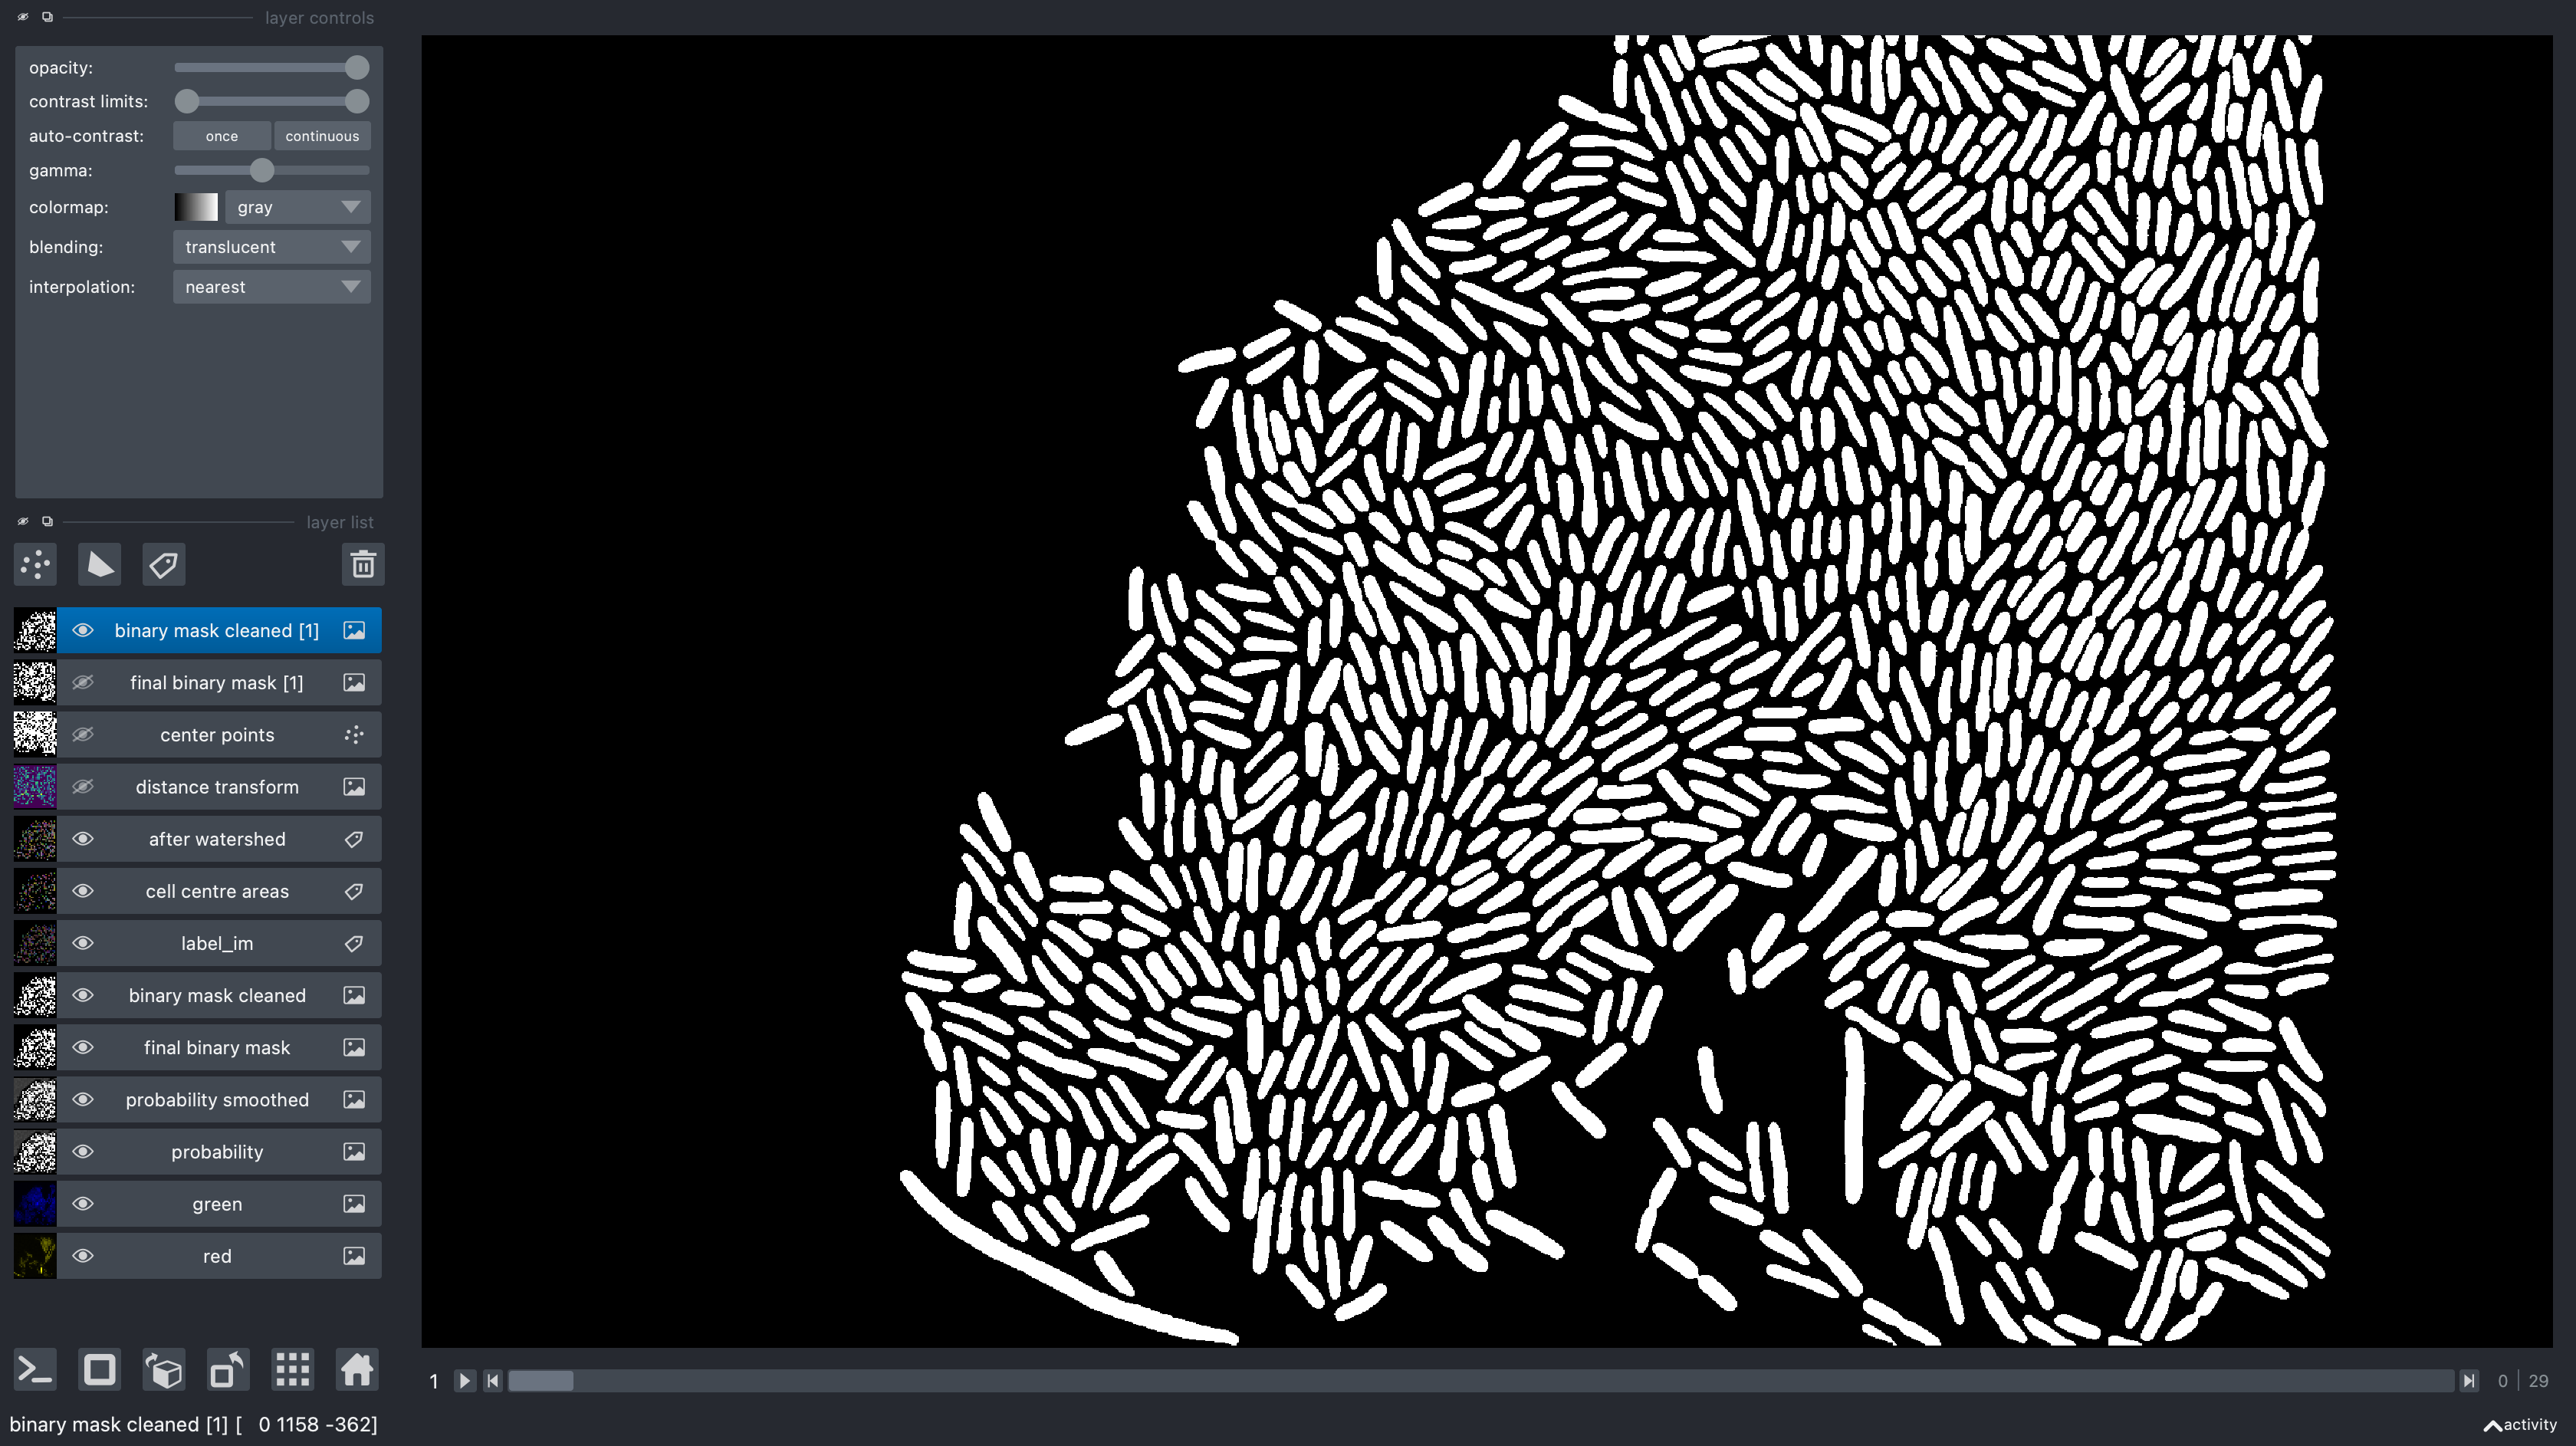

In [26]:
nbscreenshot(viewer)

> **Exercise** 
> 
> Now it is time to choose a final threshold value. Enter the value you have chosen below.  
> Hint: the slider position shows the index in the `thresholds_to_try` array we defined above


In [22]:
#choose your favorite method or enter a manually chosen value
final_threshold = 0.67

#threshold and add to viewer
bin_mask = seg_cell_sm > final_threshold
mask_layer_final = viewer.add_image(bin_mask, name='final binary mask',colormap='gray')

We can now remove the interactive threshold layer from the viewer.

In [23]:
viewer.layers.remove("binary mask int")

----
### 3. Clean up semantic segmentation using morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a size parameter, which is the minimum size (in pixels) of accepted holes or objects.

In [24]:
max_hole_size = 40 # maximum area of holes that will be filled (in pixels)
min_cell_size = 150 # minimum area of objects to keep (in pixels)

holes_removed = da.map_blocks(morphology.remove_small_holes, bin_mask, max_hole_size)
bin_mask_clean = da.map_blocks(morphology.remove_small_objects, holes_removed, min_cell_size)

mask_layer_clean = viewer.add_image(bin_mask_clean, name='binary mask cleaned',colormap='gray')

> **Exercise**
>
> Try finding good values for `max_hole_size` and `min_cell_size`, by changing the parameters above.  
> Spend max 5 min on this step!

*(Technical note `skimage.morphology` only works on 2D/3D image data, not on time stacks, we thus have to apply it to each frame separately, luckily `da.map_blocks()` can take care of that for us)*

---
### 4. Convert semantic segmentation into instance segmentation

Now we are ready to label the connected components of this image. This means that each object will be assigned a unique number. For this we can use the [`skimage.measure.labels()`](https://scikit-image.org/docs/dev/api/skimage.measure.html) function.
To add labels to Napari, we can use the `add_label()` function.

You can change the colors assigned to cells, using the shuffle button in upper left corner. 

In [13]:
#again we will need to loop over the time using map_blocks
label_im = da.map_blocks(label, bin_mask_clean)
label_layer = viewer.add_labels(label_im, opacity=0.5)

> **Exercise**
> 
> Inspect the segmentation. Do you find any problems? Think about what we need to do next.

---
### 5. Post-process instance segmentation by separating merged cells using watershed algorithm

We can see that tightly packed cells are sometimes assigned the same label.

A better segmentation would assign different labels to different cells. 

Typically we use [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) for this purpose. This requires two steps: 1) using a so-called [distance transform](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html) we  calculate the distance of each pixel to the object boundary 2) we need to find center points (called *markers*) for each object. We place *markers* at the centre of each object, and these labels are expanded until they meet an edge or an adjacent marker.

The trick, then, is how to find these markers. For spherical cells, there is a commonly used strategy that works quite well: we can simply find the local maxima of the distance transform (we provide the code for this below for reference).

For rod shape cells, this works quite badly, though. Another way to find cell centers is by using a very high threshold for the probability map, as probabilities are typically  highest in the cell centre. Then we can use these regions as markers for the watershed.

In [14]:
#set threshold to use to find cell centers
center_threshold = 0.65

center_seg = seg_cell_sm > center_threshold
center_markers = da.map_blocks(label, center_seg)
    
centre_layer = viewer.add_labels(center_markers, name='cell centre areas')   

> **Exercise**
> 
> Find a good value to use for `center_threshold` such that nearby cells have different center markers (without chopping cells into parts).  
> Spend max 5 min on this step!

Once we have the center points we can further segment the image by using the watershed: we calculate the distance using [scipy.ndimage.morphology.distance_transform_edt](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html) and then apply the watershed using [`skimage.segmentation.watershed`](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed):

In [15]:
#we need a wrapper function to tranform named arguments into positional arguments to make things work with Dask
def watershed(dist, markers, mask):
    return segmentation.watershed(-dist, markers=markers, mask=mask)    

In [16]:
#calculate distance to edge of mask
dist_transform = da.map_blocks(ndi.distance_transform_edt, bin_mask_clean)   

#run watershed
labels_final = da.map_blocks(watershed, -dist_transform, center_markers, bin_mask_clean, chunks=(1,*bin_mask_clean.shape[-2:]))

#add to Napari
watershed_layer = viewer.add_labels(labels_final, name='after watershed')   

---
### Concluding comments on segmentation

The watershed should have cut clusters of cells apart, improving the segmentation by separating nearby cells.

However, you might also have seen some cells that were cut but should not have, there is often a bit of a trade-off here.
The best solution is to improve the quality of the probability map exported by Ilastik.   

There are several things you could do here to improve things:

- Include fluorescent marker if possible: segmenting on fluorescent channel is almost always better than on phase contrast
- Optimize image acquisition: the better quality the input data has, the easier and better the segmentation will be
  - Optimize signal-to-noise ratio
  - Optimize focus 
  - Throw out data with bad focus / exposure 
- Optimize Ilastik classification
  - Add extra training points in problem areas
  - Make sure your training data is diverse: include images from all your replicates
  - Make sure you include problem frames (mediocre focus, dense cell clusters) in your training data
  - Try segmenting on different color channels or combinations of them (e.g. phase + fluorescence)
    - Important note: never segment on a channel you want to quantify later, i.e. do not segment on reporter gene signal, this will create a bias in  your data.
  - Try doing deconvolution before segmentation, this will reduce the blur caused by diffraction making dense cell clusters easier to separate 

The fastest and easiest is often to simply go back to Ilastik and add some more training points. For time reasons we will skip this now, however.

---
## Data storage and retrieval 
### Storing segmentation data

Segmentation can be a time-consuming process so you might want to store the output on your HD. 
Here we store it as HDF5 for fast access from Python.

In [17]:
#we can first convert to 16bit to save some space
labels_final.astype('int16')

#store as hdf5
seg_name_hdf5 = root /  image_name.replace('.tif','_label_im.hdf5')
labels_final.to_hdf5(seg_name_hdf5, '/labels_final')

### Loading segmentation data
To load the segmentation again we can use:

In [18]:
label_data = h5py.File(seg_name_hdf5, 'r') #open 
labels_final_loaded = da.from_array(label_data['labels_final'], chunks=(1,-1,-1))

--- 

## Next step: Extracting cell properties

We will continue in the next notebook: `1_extracting_cell_properties`, to extract the properties of cells.

---

## Extra Material: Code to find markers for spherical cells with watershed algorithm

**Do not run this section now** we provide this code for reference only

In [19]:
from skimage.feature import peak_local_max

#calculate distance to edge of mask
dist_transform = da.map_blocks(ndi.distance_transform_edt, bin_mask_clean)   

#add to Napari 
dist_layer = viewer.add_image(dist_transform, name='distance transform',colormap='viridis')  

#min distance between maxima, adjust this value to slightly less than 2x the radius of the smallest cells.
min_distance = 10


#initialize empty array of right size
markers_list = np.empty((3,0))

#find maxima in distance transform
for t, dist_map in enumerate(dist_transform):
    #dist_map = filters.gaussian(dist_map, 2) 
    peak_idx = peak_local_max(dist_map.compute(), min_distance=min_distance)
    peak_idx_3d = np.insert(peak_idx.T,0,t,axis=0)
    markers_list = np.concatenate((markers_list,peak_idx_3d),axis=1)
    
#add to Napari Viewer
point_layer = viewer.add_points(
    np.transpose(markers_list),
    name='center points',
    size=4,
    n_dimensional=False)

/Users/simonvanvliet/opt/miniconda3/envs/i2i_env/lib/python3.9/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
